<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/03_FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [3]:
import pandas as pd
df = pd.read_csv('SupplyChainDataset_eda.csv')

# Category Column


1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [4]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141452 

Suspected:  35005 

Fraud:  4062


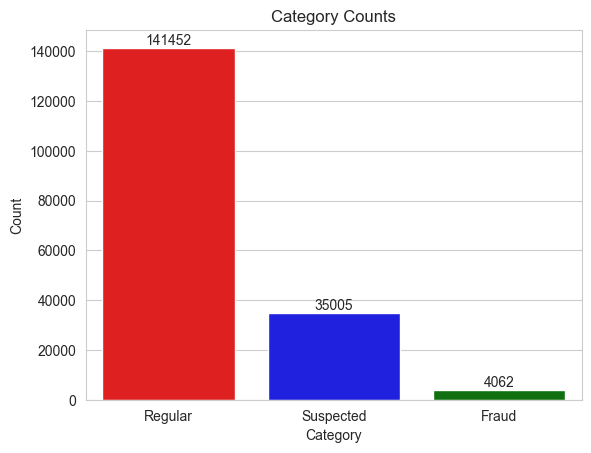

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

temp = df["Category"].value_counts()
df1 = pd.DataFrame({'Category': temp.index,'values': temp.values})

# define the colors for each category
colors = ['red', 'blue', 'green']

# create the bar plot with colors and legend
sns.set_style('whitegrid')
ax = sns.barplot(x='Category', y='values', data=df1, palette=colors)

# set the axis labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')

# add the number on top of each bar
for i, v in enumerate(df1['values']):
    ax.text(i, v, str(v), ha='center', va='bottom')


# show the plot
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

df.drop(['Customer City', 'Order Status'], axis = 1, inplace = True)

df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

df['shipping date (DateOrders)'] = df['shipping date (DateOrders)'].apply(lambda x: x.timestamp())
df['order date (DateOrders)'] = df['order date (DateOrders)'].apply(lambda x: x.timestamp())

df.to_csv('df_fraud.csv', index = False)

# Encoding

In [7]:
from sklearn.model_selection import train_test_split  

X = df.drop(['Category'], axis=1)
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

# Delivery Status
# Define the custom order
custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
le.fit(custom_order)
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [9]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Order City'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 7, 8, 11]

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

s = StandardScaler()

X_train.iloc[:, 23:] = s.fit_transform(X_train.iloc[:, 23:])
X_test.iloc[:, 23:] = s.transform(X_test.iloc[:, 23:])

/var/folders/hp/p_1k882j55xd617n87y36zt40000gn/T/ipykernel_29487/2486438858.py:8: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/var/folders/hp/p_1k882j55xd617n87y36zt40000gn/T/ipykernel_29487/2486438858.py:9: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [12]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# PCA

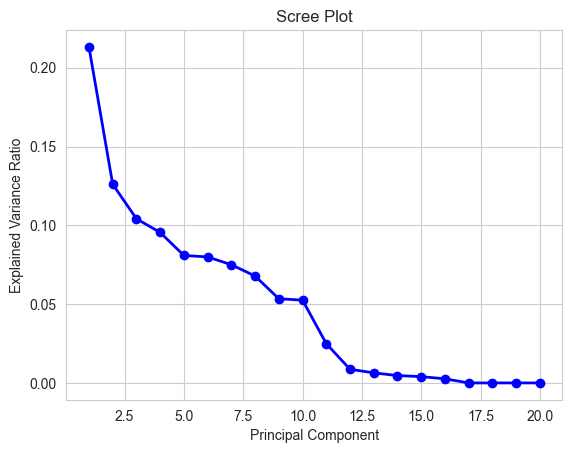


 Number of components to keep: 11


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_train = X_train.iloc[:, 23:]

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train.iloc[:, 23:])

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

# Elbow plot

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
pca_train = pca.fit_transform(X_train.iloc[:, 23:])
pca_test = pca.transform(X_test.iloc[:, 23:])

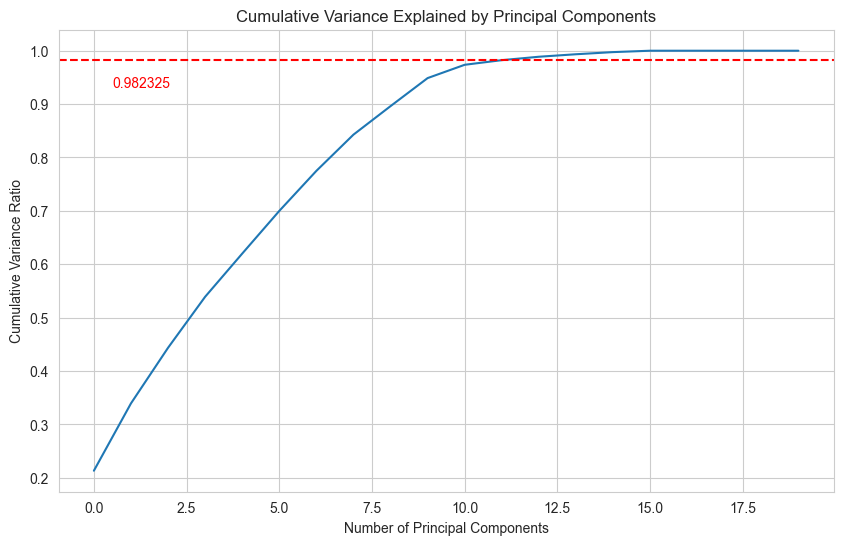

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Plotting the cumulative variance explained by principal components
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cumulative_variance_ratio)
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Variance Ratio')
ax.set_title('Cumulative Variance Explained by Principal Components')

# Indicating the cumulative variance up to the chosen number of components
num_components = num_components_to_keep
ax.axhline(y=cumulative_variance_ratio[num_components], color='r', linestyle='--')
ax.text(0.5, cumulative_variance_ratio[num_components]-0.05, 
        f'{cumulative_variance_ratio[num_components]:.6f}', color='r')

plt.show()

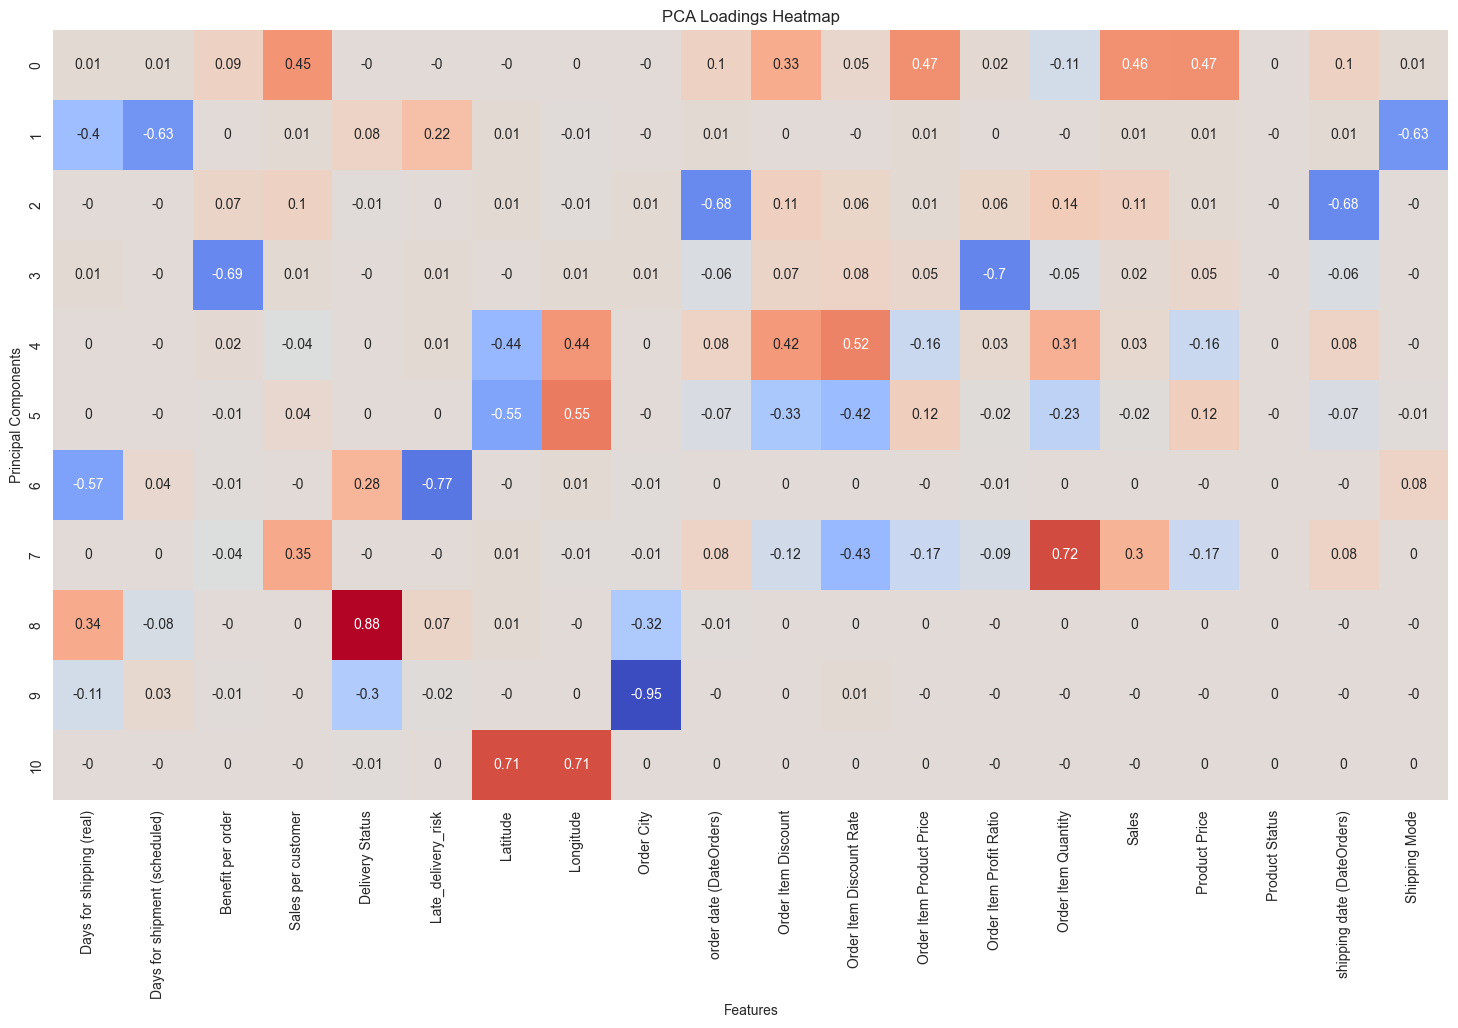

In [15]:
import seaborn as sns

cols = X_train.iloc[:, 23:].columns
# Heatmap loadings
fig = plt.figure(figsize=(18, 10))
sns.heatmap(np.round(pca.components_, 2), cmap='coolwarm', annot=True, cbar=False, xticklabels=cols)
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('PCA Loadings Heatmap')
plt.show()

In [16]:
# Get the principal components as vectors in the original feature space
pc_vectors = pca.components_

# Get the names of the original columns
column_names = cols

# Print the names of the columns chosen as principal components
num_pcs = pc_vectors.shape[0]
for i in range(num_pcs):
    pc_name = f'PC{i+1}'
    pc_loadings = pc_vectors[i]
    relevant_col_indices = np.where(np.abs(pc_loadings) >= 0.60)[0]
    relevant_columns = column_names[relevant_col_indices]
    relevant_loadings = pc_loadings[relevant_col_indices]
    print(f'{pc_name}:')
    for j in range(len(relevant_columns)):
        print(f'{relevant_columns[j]}: {relevant_loadings[j]}')
    print()


PC1:

PC2:
Days for shipment (scheduled): -0.627210101881943
Shipping Mode: -0.6273105809915575

PC3:
order date (DateOrders): -0.6832235743704222
shipping date (DateOrders): -0.6832453047991954

PC4:
Benefit per order: -0.6930653693666365
Order Item Profit Ratio: -0.7028547645209521

PC5:

PC6:

PC7:
Late_delivery_risk: -0.770832911093176

PC8:
Order Item Quantity: 0.7153637281901021

PC9:
Delivery Status: 0.8754127642213438

PC10:
Order City: -0.9457026724371704

PC11:
Latitude: 0.7070756540428315
Longitude: 0.7070893246943196



In [17]:
onehot_data_train = X_train.iloc[:, :23]
onehot_data_test = X_test.iloc[:, :23]

X_train = pd.concat([pd.DataFrame(pca_train), pd.DataFrame(onehot_data_train)], axis=1)
X_test = pd.concat([pd.DataFrame(pca_test), pd.DataFrame(onehot_data_test)], axis=1)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [18]:
X_train.columns = range(len(X_train.columns))
X_test.columns = range(len(X_test.columns))

# Models

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

lr = LogisticRegression(class_weight='balanced')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average=None))

[[  811     0     1]
 [ 1528 24464  2299]
 [  729  1793  4479]]
[0.99876847 0.8647273  0.63976575]


/Users/giacomorossi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', max_depth=4)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average=None))

[[  812     0     0]
 [ 3407 24865    19]
 [  741  2294  3966]]
[1.         0.87890142 0.5664905 ]


In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average=None))

[[  567     2   243]
 [    0 28265    26]
 [  296  2260  4445]]
[0.69827586 0.99908098 0.6349093 ]


In [28]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(max_depth=4, n_estimators=1000)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average=None))

[[  574     0   238]
 [    0 28238    53]
 [  248  2232  4521]]
[0.70689655 0.99812661 0.64576489]


In [29]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced')

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average=None))

[[  500     6   306]
 [    0 26622  1669]
 [  247  1734  5020]]
[0.61576355 0.94100597 0.71704042]


In [30]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

vc = VotingClassifier(estimators=[('xgb', XGBClassifier()),
                                     ('lr', LogisticRegression(class_weight='balanced', max_iter=1000))],
                         voting='soft')

vc.fit(X_train, y_train)

with open('vc.pkl', 'wb') as file:
    pickle.dump(vc, file)

y_pred = vc.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average=None))

[[  791     0    21]
 [   21 28151   119]
 [  640  2188  4173]]
[0.97413793 0.99505143 0.59605771]


In [31]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

print(vc)

y_pred = vc.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, vc.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_t

/Users/giacomorossi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Confusion Matrix
 [[  791     0    21]
 [   21 28151   119]
 [  640  2188  4173]] 

Recalls [0.97413793 0.99505143 0.59605771]
Precisions [0.54476584 0.9278816  0.96754   ]


/Users/giacomorossi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

